In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('RFM_ht_data.csv')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00




# Задача:
провести  RFM-анализ пользователей, в каждом подсегменте поделив пользователей на 4 класса.

In [4]:
# Посмотрим на данные и преобразуем их к нужным типам:

In [5]:
df.shape

(332730, 4)

In [6]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

In [7]:
df.isnull().sum()

InvoiceNo       0
CustomerCode    0
InvoiceDate     0
Amount          0
dtype: int64

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df.CustomerCode = df.CustomerCode.apply(str)
df.InvoiceNo = df.InvoiceNo.apply(str)

In [10]:
df.InvoiceDate.describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [11]:
# Найдем последний день в датасете.
#Количество дней, прошедших с момента последней покупки, будем считать от максимальной даты покупки в датасете.

last_date = df.InvoiceDate.max()

last_date

Timestamp('2020-09-30 00:00:00')

In [12]:
# Подготавливаем таблицу rfm с колонками по Recency, Frequency, Monetary.

rfm = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency, кол-во дней с посл. покупки
                                      'InvoiceNo': lambda x: len(x), # Frequency, кол-во заказов
                                      'Amount': lambda x: x.sum()}) # Monetary, сумма по всем заказам

In [13]:
rfm.head()

,InvoiceDate,InvoiceNo,Amount
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


In [14]:
rfm.InvoiceDate = rfm.InvoiceDate.astype(int)

rfm.rename(columns = {'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'Amount': 'Monetary_value'}, inplace = True)

In [15]:
rfm

,Recency,Frequency,Monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [16]:
# Считаем квантили для наших трех колонок - составление четырех равных частей на основе доступных значений — для 
# дальнешего расчета показателей RFM.

quantiles = rfm.quantile(q = [0.25, 0.5, 0.75])

quantiles

,Recency,Frequency,Monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [17]:
# Cоздаем копию таблицы, в ней будем работать далее.

rfmSegmentation = rfm

In [18]:
# Задаем функции для присвоения уровня (класса) RFM:

def RClass(value, parameter_name, quantile_table):
    if value <= quantile_table[parameter_name][0.25]:
        return 4
    elif value <= quantile_table[parameter_name][0.5]:
        return 3
    elif value <= quantile_table[parameter_name][0.75]:
        return 2
    else:
        return 1
    
def FMClass(value, parameter_name, quantile_table):
    if value <= quantile_table[parameter_name][0.25]:
        return 1
    elif value <= quantile_table[parameter_name][0.5]:
        return 2
    elif value <= quantile_table[parameter_name][0.75]:
        return 3
    else:
        return 4

In [19]:
# применяем функции, создаем соответствующие колонки:

rfmSegmentation["R_Quantile"] = rfmSegmentation.Recency.apply(RClass, args=('Recency', quantiles))

rfmSegmentation["F_Quantile"] = rfmSegmentation.Frequency.apply(FMClass, args=('Frequency', quantiles))

rfmSegmentation["M_Quantile"] = rfmSegmentation.Monetary_value.apply(FMClass, args=('Monetary_value', quantiles))

rfmSegmentation["RFMClass"] = rfmSegmentation.R_Quantile.map(str) \
                              + rfmSegmentation.F_Quantile.map(str) \
                              + rfmSegmentation.M_Quantile.map(str)

In [20]:
# получившаяся таблица 

rfmSegmentation

,Recency,Frequency,Monetary_value,R_Quantile,F_Quantile,M_Quantile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,1,1,2,112
02213042,22,3,9685.48,1,3,4,134
02213071,29,1,415.00,1,1,1,111
02213088,23,1,305.00,1,1,1,111
02213092,25,1,1412.88,1,1,2,112
...,...,...,...,...,...,...,...
99099927,10,1,961.10,2,1,2,212
99099936,0,1,1521.78,4,1,2,412
99099959,8,2,1444.56,3,2,2,322


In [21]:
# Построим график со значениями медианной суммы заказов:

In [28]:
%config InlineBackend.figure_format = 'svg'  # в svg графики более четкие и разборчивые


# настраиваем размеры и цвета:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['image.cmap'] = 'plasma'

<AxesSubplot:xlabel='F_Quantile', ylabel='R_Quantile'>

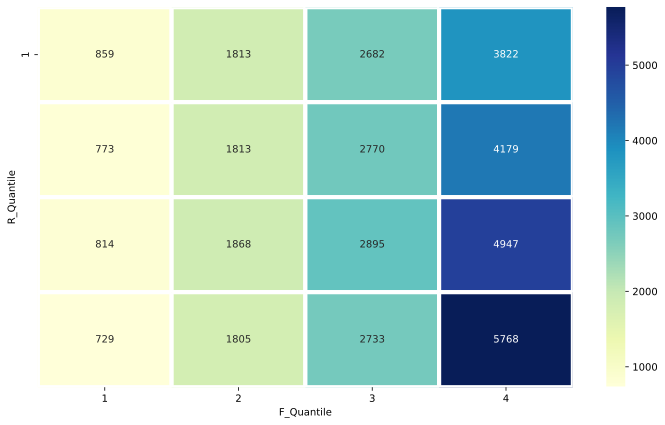

In [29]:
viz = rfmSegmentation \
.pivot_table(index = 'R_Quantile', columns = 'F_Quantile', values = 'Monetary_value', aggfunc = np.median) \
.applymap(int)


sns.heatmap(viz, cmap = "YlGnBu", annot = True, fmt = ".0f", linewidths = 4.15, annot_kws = {"size": 10}, yticklabels = 4)

In [30]:
# то же самое в табличном виде:
viz

F_Quantile,1,2,3,4
R_Quantile,,,,
1,859,1813,2682,3822
2,773,1813,2770,4179
3,814,1868,2895,4947
4,729,1805,2733,5768


<AxesSubplot:xlabel='M_Quantile', ylabel='R_Quantile'>

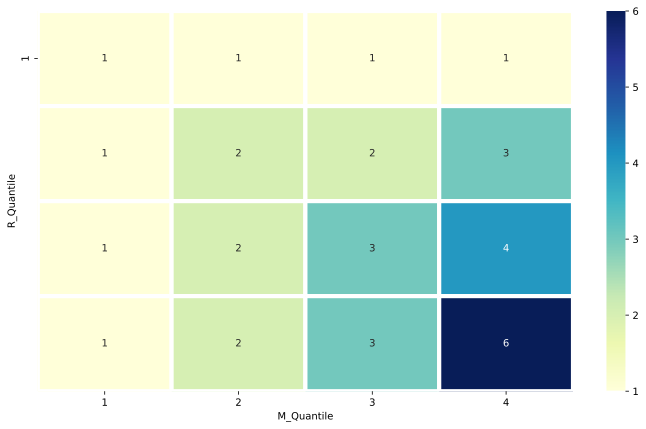

In [31]:
# а это график со значениями медианной частоты покупок:

viz2 = rfmSegmentation \
.pivot_table(index = 'R_Quantile', columns = 'M_Quantile', values = 'Frequency', aggfunc = np.median) \
.applymap(int)


sns.heatmap(viz2, cmap = "YlGnBu", annot = True, fmt = ".0f", linewidths = 4.15, annot_kws = {"size": 10}, yticklabels = 4)


### Наибольшая сумма заказов оказалась в сегменте 444 - у тех, кто покупал недавно и часто.
### Наименьшая сумма заказов - у сегмента 411, то есть у тех, кто покупал совсем недавно, но единожды. 
Вероятно, на это могло повлиять последнее промо с недорогими товарами.


### База лояльных клиентов с крупными заказами:

In [32]:
loyal_valuable_base = rfmSegmentation. \
query('F_Quantile == 4 and M_Quantile >= 3') \
.sort_values('Monetary_value', ascending=False)

loyal_valuable_base.head()

,Recency,Frequency,Monetary_value,R_Quantile,F_Quantile,M_Quantile,RFMClass
CustomerCode,,,,,,,
15001294,0,24,711487.71,4,4,4,444
13077590,0,18,425243.69,4,4,4,444
99003061,0,90,398759.35,4,4,4,444
19093056,0,28,391437.41,4,4,4,444
13032521,0,106,389309.92,4,4,4,444


In [33]:
(loyal_valuable_base.RFMClass.count() / rfmSegmentation.RFMClass.count()).round(2)

0.2

###  Лояльные клиенты с крупными заказами составляют 20% нашей базы.